<a href="https://colab.research.google.com/github/sspaulc/TED_TALKS_VIEWS_PREDICTION/blob/main/Ted_Talk_Views_Prediction_13_SMAPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement-- TED is devoted to spreading powerful ideas on just about any topic. These datasets contain over 4,000 TED talks including transcripts in many languages. Founded in 1984 by Richard Salman as a nonprofit organization that aimed at bringing experts from the fields of Technology, Entertainment, and Design together, TED Conferences have gone on to become the Mecca of ideas from virtually all walks of life. As of 2015, TED and its sister TEDx chapters have published more than 2000 talks for free consumption by the masses and its speaker list boasts of the likes of Al Gore, Jimmy Wales, Shahrukh Khan, and Bill Gates. The main objective is to build a predictive model, which could help in predicting the views of the videos uploaded on the TEDx website

# Importing Libraires:


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

In [2]:
from wordcloud import WordCloud,ImageColorGenerator

# Collecting data:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [214]:
#Read the data

data= pd.read_csv("/content/gdrive/MyDrive/AlmaBetter/Almabetter/Capstone Projects/Ted Talk Views Prediction/data_ted_talks.csv")


In [215]:
data.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript'],
      dtype='object')

# **Exploratory Data Analysis:**

#Hypotheses:

1. Events with more counts will have more views

2. Medium Duration of videos have most views

3. Most popular speakers like Alex Gendler will have more views

4. Number of languages it is available in will have more views.

5. Occupations like 'Activist' will have most views.

6. Topics like 'Technology' will have most views.

7. Older videos will have more views.

8. More comments will have more views.

9. More number of tags will have more views.

10. Videos published on Fridays will have more views.

11. Topics from Related talks will have direct influence from views.


##**1. Events:**

In [73]:
len(data['event'].unique())

459

There are 459 unique values for events. Let us rectify that first. Every event that has occurred in the same year will be considered in the same bin.

In [216]:
# initialise all values as 'Other' to assign this category
# to all entries that don't fit into the chosen categories
data['event_category'] = 'Other'

for i in range(len(data)):
    if data['event'][i][0:5]=='TED20':
        data['event_category'][i] = 'TED2000s'
    elif data['event'][i][0:5]=='TED19':
        data['event_category'][i] = 'TED1900s'
    elif data['event'][i][0:4]=='TEDx':
        data['event_category'][i] = "TEDx"
    elif data['event'][i][0:7]=='TED@BCG':
        data['event_category'][i] = 'TED@BCG'
    elif data['event'][i][0:4]=='TED@':
        data['event_category'][i] = "TED@"
    elif data['event'][i][0:8]=='TEDSalon':
        data['event_category'][i] = "TEDSalon"
    elif data['event'][i][0:9]=='TEDGlobal':
        data['event_category'][i] = 'TEDGlobal'
    elif data['event'][i][0:8]=='TEDWomen':
        data['event_category'][i] = 'TEDWomen'
    elif data['event'][i][0:6]=='TEDMED':
        data['event_category'][i] = 'TEDMED'
    elif data['event'][i][0:3]=='TED':
        data['event_category'][i] = 'TEDOther'

Let us see the Event with most counts:

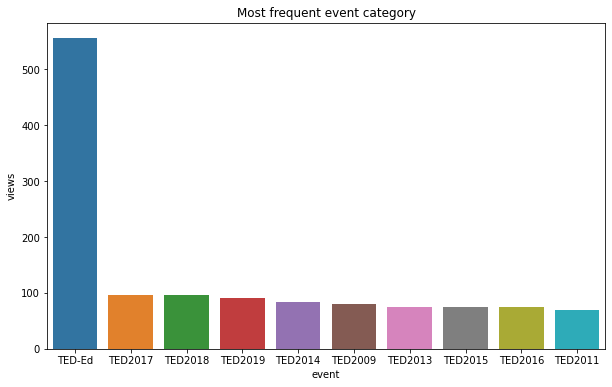

In [217]:
#let's find the most frequent event categories
freq_event_df=data[['event','views']].groupby('event').agg({'views' : 'count'}).nlargest(10,['views'])
freq_event_df.reset_index(inplace=True)
freq_event_df

#plotting Most frequent event category
plt.figure(figsize=(10,6))
plt.title('Most frequent event category')
sns.barplot(x='event',y='views',data=freq_event_df)

According to this data, TED-Ed should have most views as they were most in count.

Text(0, 0.5, 'Views in 10 millions')

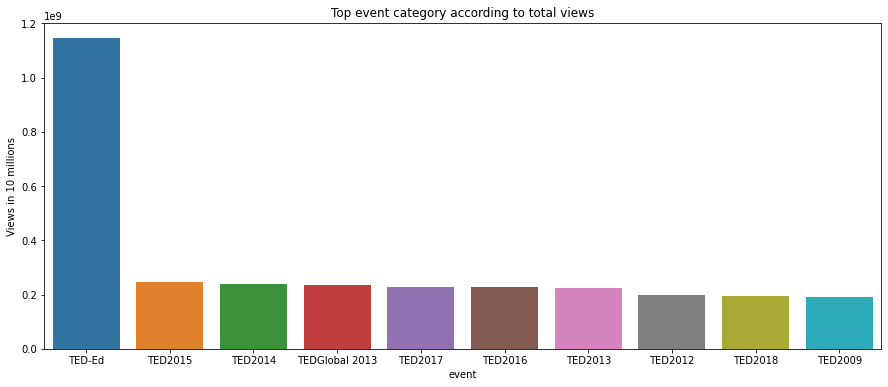

In [218]:
#let's find the most popular event categories
pop_event_df=data[['event','views']].groupby('event').agg({'views' : 'sum'}).nlargest(10,['views'])
pop_event_df.reset_index(inplace=True)

#plotting the Top event category according to total views
plt.figure(figsize=(15,6))
plt.title('Top event category according to total views')
sns.barplot(x='event',y='views',data=pop_event_df)

plt.ylabel('Views in 10 millions')

First hypothesis is true.

## **2. Duration:**

Text(0, 0.5, 'Views in millions')

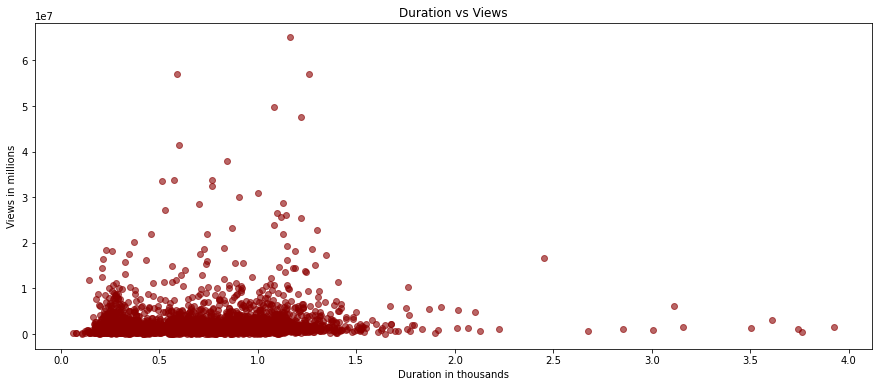

In [219]:
plt.scatter(x= data['duration']/1000,y=data['views'],color='darkred',alpha=0.6)

plt.title('Duration vs Views')

plt.xlabel('Duration in thousands')

plt.ylabel('Views in millions')



Most vidoes with lesser duration are more closely related to views.

## **3. Speakers:**

In [220]:
data['speaker_1'][0]

'Al Gore'

In [221]:
#Extarcting the records of top 5 most viewed videos
pop_df=data.nlargest(5, ['views'])
pop_df[['speaker_1','views','title']]

,speaker_1,views,title
4,Sir Ken Robinson,65051954,Do schools kill creativity?
1296,Amy Cuddy,57074270,Your body language may shape who you are
2062,James Veitch,56932551,This is what happens when you reply to spam email
646,Simon Sinek,49730580,How great leaders inspire action
796,Brené Brown,47544833,The power of vulnerability


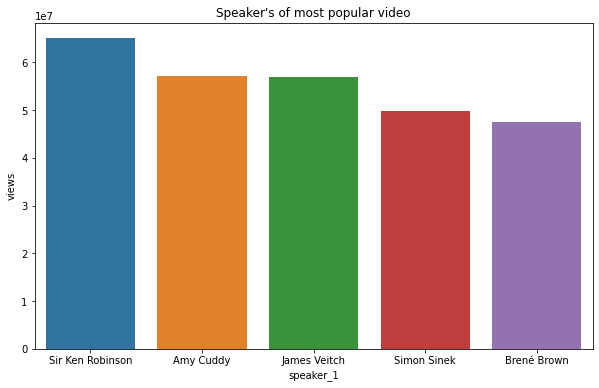

In [222]:
#finding Speaker's of most popular video
plt.figure(figsize=(10,6))
plt.title("Speaker's of most popular video")
sns.barplot(x='speaker_1',y='views',data=pop_df)

Sir Ken Robinson's talk on "Do Schools Kill Creativity?" is the most popular TED Talk of all time with more than 65 million views.
It is closely followed by Amy Cuddy talk on "Your body language may shape who you are" with more than 57 million views.
There is only one talk that has crossed 60 million mark while 3 talks have crossed 50 million mark.

Text(0, 0.5, 'Views in 10 millions')

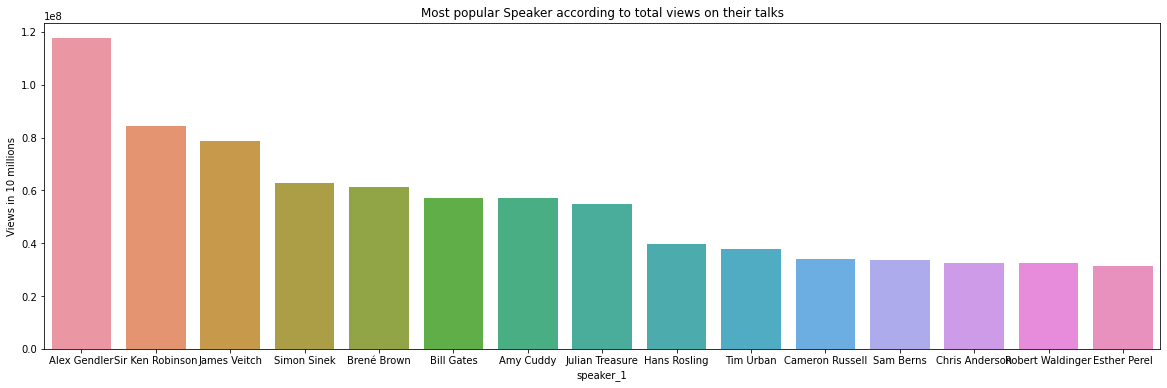

In [223]:
#finding most popular speaker from the dataset
pop_speaker_df=data.groupby('speaker_1').agg({'views' : 'sum'}).nlargest(15,['views'])
pop_speaker_df.reset_index(inplace=True)

#printing most popular Speaker according to total views on their talks
plt.figure(figsize=(20,6))
plt.title('Most popular Speaker according to total views on their talks')
sns.barplot(x='speaker_1',y='views',data=pop_speaker_df)
plt.ylabel('Views in 10 millions')

Alex Gendler is one of the most popular guests on Ted Talks and thus he has the highest number of views. 

And thus my hypothesis was correct.

One of his best videos being Building the Brooklyn bridge. 




# **3. Number of Languages:**

In [224]:
#First row
data['available_lang'][0]

"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'fr-ca', 'gl', 'gu', 'he', 'hi', 'hr', 'hu', 'id', 'it', 'ja', 'ko', 'lt', 'lv', 'mk', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sk', 'sl', 'sq', 'sr', 'sv', 'sw', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'zh-cn', 'zh-tw']"

I need to convert the data type and then get the count of languages available.

In [225]:
#Function to use eval function to convert string to list.
def convert_string_to_original_dtype(x):
  try:
    return eval(x)
  except TypeError:
    pass

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

In [227]:
data['available_lang']= data['available_lang'].apply(convert_string_to_original_dtype)

In [228]:
#Function to calculate the count of languages

def length(x):
  return len(x)

In [229]:
data['count_lang']= data['available_lang'].apply(length)

In [230]:
#Number of languages of the most popular videos
count_df=data.groupby('count_lang').agg({'views' : 'sum'}).nlargest(15,['views'])

In [231]:
count_df

,views
count_lang,
26,399588147
31,371001647
27,360321107
28,348698187
23,346063562
25,340633791
29,333023681
34,330787782
32,327429954


Text(0, 0.5, 'Views in 10 millions')

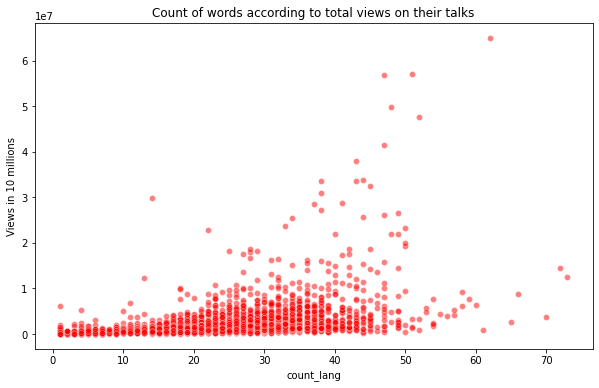

In [232]:
#printing count of words according to total views on their talks
plt.figure(figsize=(10,6))
plt.title('Count of words according to total views on their talks')
sns.scatterplot(x=data['count_lang'],y=data['views'],color='r',alpha=0.5)

plt.ylabel('Views in 10 millions')

My hypothesis is wrong. Number of languages doesn't effect the views.

Detrmining the geography from the languages:

In [233]:
data[data['count_lang']== data['count_lang'].max()]

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,event_category,count_lang
929,1183,Try something new for 30 days,Matt Cutts,{0: 'Matt Cutts'},{0: ['technologist']},"{0: 'An early employee at Google, Matt Cutts w...",12481445,2011-03-03,2011-07-01,TED2011,en,"[ar, arq, az, be, bg, bn, bs, ca, cs, da, de, ...",916.0,207,"['culture', 'success']","{947: 'Keep your goals to yourself', 282: 'Wha...",https://www.ted.com/talks/matt_cutts_try_somet...,"Is there something you've always meant to do, ...","A few years ago, I felt like I was stuck in a ...",TED2000s,73


In [234]:
maximum=data[data['count_lang']== data['count_lang'].max()]

In [235]:
lab_list= [item for item in maximum['available_lang']]

In [236]:
lab_list

[['ar',
  'arq',
  'az',
  'be',
  'bg',
  'bn',
  'bs',
  'ca',
  'cs',
  'da',
  'de',
  'el',
  'en',
  'eo',
  'es',
  'et',
  'eu',
  'fa',
  'fi',
  'fil',
  'fr',
  'fr-ca',
  'gl',
  'he',
  'hi',
  'hr',
  'hu',
  'hy',
  'id',
  'it',
  'ja',
  'ka',
  'kk',
  'ko',
  'ku',
  'ky',
  'lt',
  'ltg',
  'lv',
  'mk',
  'mn',
  'mr',
  'ms',
  'my',
  'nb',
  'ne',
  'nl',
  'pl',
  'pt',
  'pt-br',
  'ro',
  'ru',
  'si',
  'sk',
  'sl',
  'sq',
  'sr',
  'sv',
  'szl',
  'ta',
  'te',
  'tg',
  'th',
  'tl',
  'tr',
  'tt',
  'ug',
  'uk',
  'uz',
  'vi',
  'zh',
  'zh-cn',
  'zh-tw']]

Geography isn't clear from the available languages.

# **5. Occupation:**

In [237]:
data['occupations'][0]

"{0: ['climate advocate']}"

Convert String to dictionary and obtain the value from the list:

In [238]:
data['occupations']=data['occupations'].apply(convert_string_to_original_dtype)

In [239]:
#Function to convert list to string
def list_to_string(x):
  for item in x:
    return item

In [240]:
data['occupations'].isnull().sum()

522

In [241]:
#Function to obtain occupation 

def get_occupation(x):
  try:
    for key,value in x.items():
      return value
  except AttributeError:
    return ['Unknown']

In [242]:
data['occupations']= data['occupations'].apply(get_occupation)

In [243]:
data['occupations']=data['occupations'].apply(list_to_string)

In [244]:
data['occupations'][0]

'climate advocate'

[Text(0.5, 1.0, "top 15 most frequent speaker's occupations")]

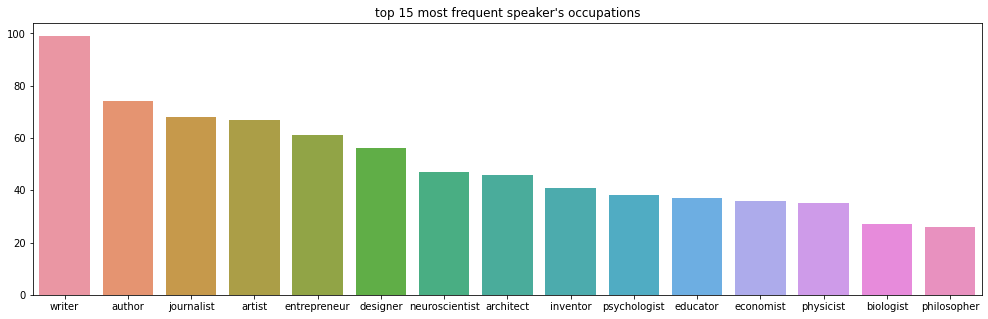

In [245]:
#Printing the top 15 most frequent speaker's occupations
occ_df=data[data['occupations']!='Unknown']
fig,ax=plt.subplots(figsize=(17,5))
a=sns.barplot(x=occ_df['occupations'].value_counts(ascending=False).head(15).index, 
              y=occ_df['occupations'].value_counts(ascending=False).head(15).values, ax=ax)
a.set(title="top 15 most frequent speaker's occupations")

There are 55651 words in the combination of all Occupations.


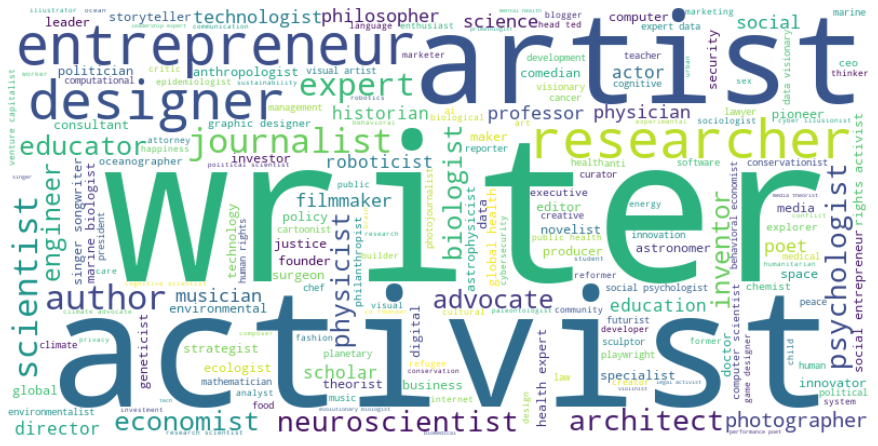

In [246]:
#Let us see some of the most commonly occuring occupations by word cloud

#making of word cloud from title column
text = " ".join(topic for topic in occ_df.occupations.astype(str))
print ("There are {} words in the combination of all Occupations.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (15,6)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Entrepreneur, Activist, designer have some of the most counts. Let us see what it has to do with the views.

Text(0, 0.5, 'Views in 10 millions')

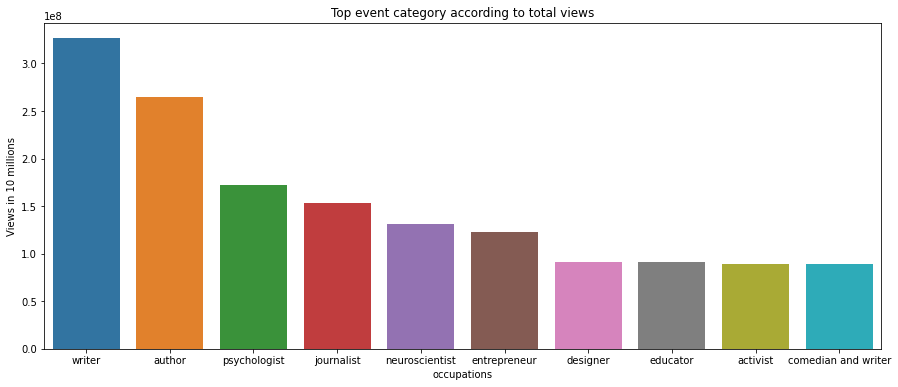

In [247]:
#let's find the most popular occupations according to views
pop_occ_df=occ_df[['occupations','views']].groupby('occupations').agg({'views' : 'sum'}).nlargest(10,['views'])
pop_occ_df.reset_index(inplace=True)

#plotting the Top event category according to total views
plt.figure(figsize=(15,6))
plt.title('Top event category according to total views')
sns.barplot(x='occupations',y='views',data=pop_occ_df)

plt.ylabel('Views in 10 millions')

Writer,author like most frequently occuring occupations also have some of highest views.

## **6.Topics:**

To determine the hidden abstract and actual topics that may or may not have been tagged I will be using the Transcript column.

### Word Preprocessing:

In [248]:
import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [249]:
from keras.preprocessing.text import Tokenizer

In [250]:
#maximum number of words to keep
tokenizer = Tokenizer(nb_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(data['transcript'])

Word Normalizing:

In [251]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

data['transcript'] = normalize(data['transcript'])
print(data['transcript'][0])

thank you so much chris and its truly a great honor to have the opportunity to come to this stage twice im extremely grateful i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night and i say that sincerely partly because mock sob i need that laughter put yourselves in my position laughter i flew on air force two for eight years laughter now i have to take off my shoes or boots to get on an airplane laughter applause ill tell you one quick story to illustrate what thats been like for me laughter its a true story  every bit of this is true soon after tipper and i left the  mock sob white house  laughter we were driving from our home in nashville to a little farm we have 50 miles east of nashville driving ourselves laughter i know it sounds like a little thing to you but  laughter i looked in the rearview mirror and all of a sudden it just hit me there was no motorcade back there laughter youve heard of p

Topic Modelling by Geneism and Tfidf Vectorizer:

In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [253]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.25,min_df=5)
doc_term_matrix = tfidf_vectorizer.fit_transform(data['transcript'].values.astype('U'))

In [254]:
#Probability matrix of the probabilities of words

from sklearn.decomposition import NMF

nmf = NMF(n_components=7, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [255]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['data', 'language', 'book', 'hes', 'computer', 'art', 'video', 'students', 'design', 'kids']


Top 10 words for topic #1:
['solar', 'stars', 'species', 'planets', 'energy', 'ocean', 'planet', 'light', 'universe', 'earth']


Top 10 words for topic #2:
['musicians', 'singing', 'piano', 'guitar', 'ends', 'song', 'play', 'musical', 'sound', 'music']


Top 10 words for topic #3:
['drugs', 'drug', 'health', 'dna', 'blood', 'disease', 'cell', 'patients', 'cancer', 'cells']


Top 10 words for topic #4:
['food', 'health', 'china', 'dollars', 'global', 'government', 'city', 'cities', 'africa', 'countries']


Top 10 words for topic #5:
['violence', 'black', 'girl', 'gender', 'womens', 'sex', 'woman', 'girls', 'men', 'women']


Top 10 words for topic #6:
['signals', 'cortex', 'stress', 'mental', 'activity', 'sleep', 'memory', 'brains', 'neurons', 'brain']




In [256]:
topic_values = nmf.transform(doc_term_matrix)
data['Topic_Cluster'] = topic_values.argmax(axis=1)

In [257]:
data['Topic_Cluster'].unique()

array([4, 0, 2, 6, 5, 1, 3])

In [258]:
# Replace the the values

replace_values={0:'Technology',1:'Science',2:'Music',3:'Health',4:'International Affairs',5:'Social Issues',6:'Mental Health'}

data['Topic_Cluster']= data['Topic_Cluster'].map(replace_values)

In [259]:
top_topics= data[['Topic_Cluster','views']].groupby('Topic_Cluster').agg({'views':'sum'}).nlargest(10,['views'])

In [260]:
data.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript', 'event_category',
       'count_lang', 'Topic_Cluster'],
      dtype='object')

In [261]:
top_topics.reset_index(inplace=True)

In [262]:
top_topics

,Topic_Cluster,views
0,Technology,3767194061
1,International Affairs,1280570507
2,Science,1030527730
3,Mental Health,912270010
4,Social Issues,723353830
5,Health,541900802
6,Music,346945383


Text(0, 0.5, 'Views in 10 millions')

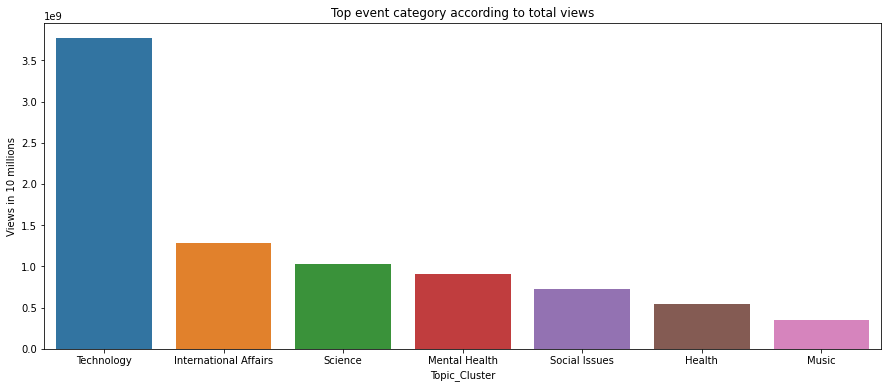

In [263]:
#plotting the Top Topic category according to total views
plt.figure(figsize=(15,6))
plt.title('Top event category according to total views')
sns.barplot(x='Topic_Cluster',y='views',data=top_topics)

plt.ylabel('Views in 10 millions')

My hypothesis is correct.

## **7. Age of The Video:**

In [264]:
import datetime

In [265]:
data['published_date'] = data['published_date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [266]:
current_date=datetime.datetime(2021,5,22)

In [267]:
data['published_year'] = data['published_date'].apply(lambda x: x.year)

In [268]:
data['age_of_video']= current_date.year- data['published_year']

In [269]:
age_views= data[['age_of_video','views']].groupby('age_of_video').agg({'views':'sum'})

In [270]:
age_views.reset_index()

,age_of_video,views
0,1,195543239
1,2,1361604924
2,3,871101863
3,4,680519097
4,5,661803437
5,6,617490537
6,7,581655293
7,8,729009369
8,9,665473046
9,10,492776405


Text(0.5, 1.0, 'Age of Video vs Views')

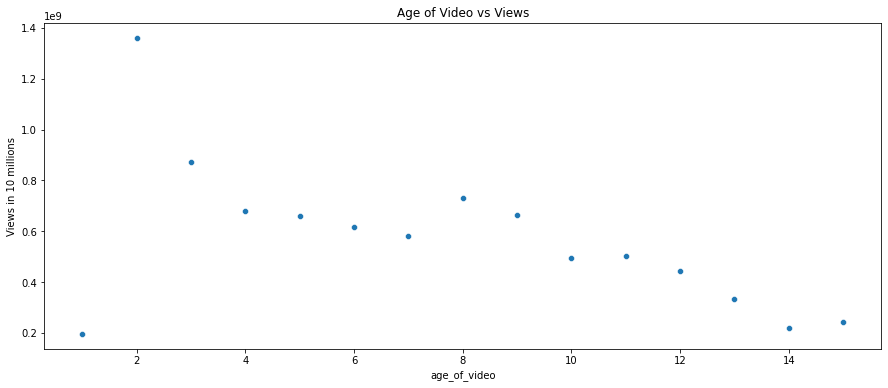

In [271]:
sns.scatterplot("age_of_video", "views", data=age_views)

plt.ylabel('Views in 10 millions')

plt.title('Age of Video vs Views')

Hypothesis can be rejected.

## **8. Comments:**

Text(0, 0.5, 'Views in 10 million')

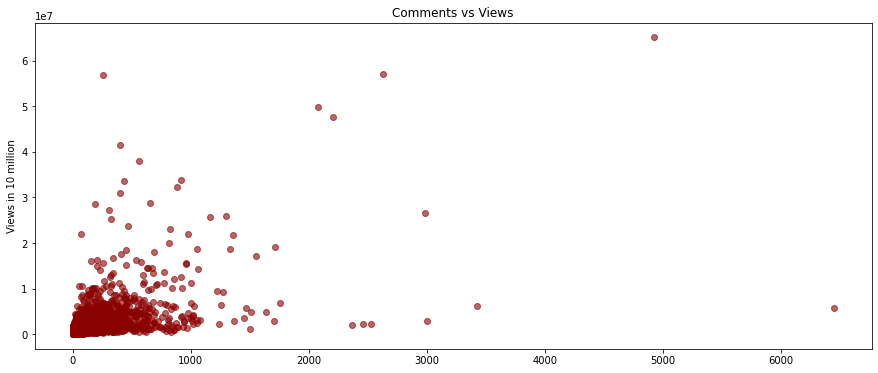

In [272]:
plt.scatter(x= data['comments'],y=data['views'],color='darkred',alpha=0.6)

plt.title('Comments vs Views')

plt.ylabel('Views in 10 million')

Hypothesis is true except for a few outliers.

##**9. Number of Tags:**

In [273]:
#Find the number of tags

def no_of_tags(x):
  return len(x)

In [274]:
data['Num_tags']= data['topics'].apply(no_of_tags)

Text(0, 0.5, 'Views in 10 millions')

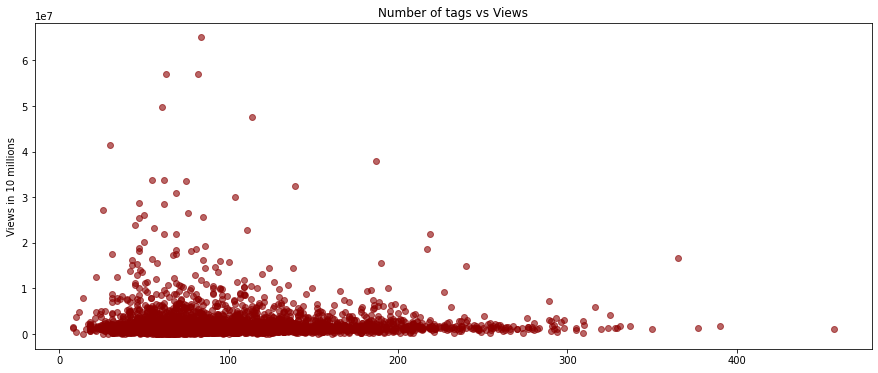

In [275]:
plt.scatter(x= data['Num_tags'],y=data['views'],color='darkred',alpha=0.6)

plt.title('Number of tags vs Views')

plt.ylabel('Views in 10 millions')

Hypothesis can be rejected.

# **10. Published Day:**

In [276]:
data['published_day'] = data['published_date'].apply(lambda x: x.weekday())

In [277]:
#encoding of release_day column with corresponding week day name
week_day={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['published_day']=data['published_day'].map(week_day)

Text(0.5, 1.0, 'Most frequent release days')

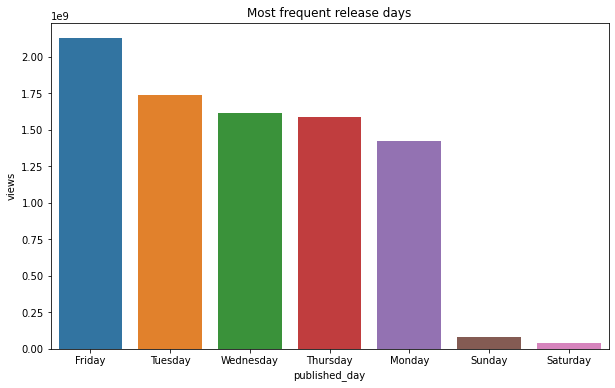

In [278]:
#checking the day of the week having maximum views 
freq_rel_day=data[['published_day','views']].groupby('published_day').agg({'views' : 'sum'})
freq_rel_day=freq_rel_day.sort_values('views',ascending=False)
freq_rel_day.reset_index(inplace=True)

# checking the day of the week having maximum views 
plt.figure(figsize=(10,6))
sns.barplot(x='published_day',y='views',data=freq_rel_day)
plt.title('Most frequent release days')

Hypothesis was correct.

# **New Feature:**


##**Related Views:**

In [279]:
data['related_talks'][0]

'{243: \'New thinking on the climate crisis\', 547: \'The business logic of sustainability\', 2093: \'The state of the climate — and what we might do about it\', 54715: \'How we can turn the tide on climate\', 29968: \'The most important thing you can do to fight climate change: talk about it\', 2339: "Climate change is happening. Here\'s how we adapt"}'

This feature is made by taking the keys from the related_talks column and assigning a level to it according to mean of the views.

In [280]:
#applying eval function on available_lang column
data['related_talks'] = data.apply(lambda row: eval(row['related_talks']), axis=1)

In [281]:
#defining a new feature called related_views
data['related_views'] = 0
#iterating through the each row and extracting the value of related_talks
for index, row in data.iterrows():
    id_list=list(row['related_talks'].keys())
    temp=0
    for i in range(len(data)):
      if (data.loc[i,'talk_id']) in id_list:
        temp+=data.loc[i,'views']

    data.loc[index,'related_views']=temp//6

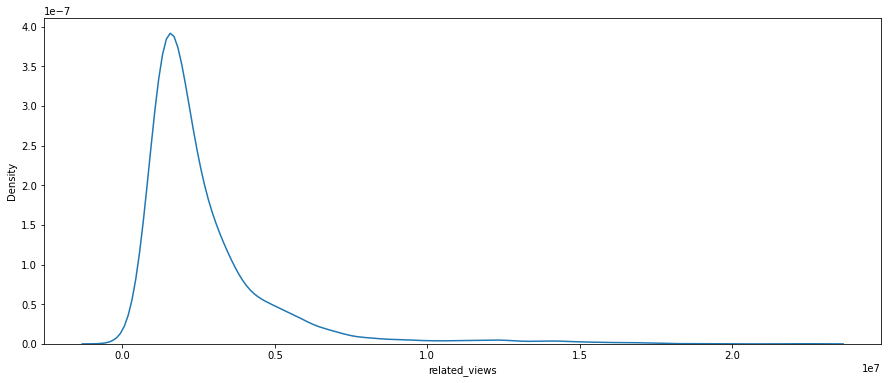

In [282]:
#Plotting the distribution

sns.kdeplot(x=data['related_views'])

It is a normally distributed curve with right skew.

In [284]:
data['related_talks'][0]

{243: 'New thinking on the climate crisis',
 547: 'The business logic of sustainability',
 2093: 'The state of the climate — and what we might do about it',
 2339: "Climate change is happening. Here's how we adapt",
 29968: 'The most important thing you can do to fight climate change: talk about it',
 54715: 'How we can turn the tide on climate'}

In [285]:
max(data['related_talks'][0].keys())

54715

In [286]:
data['related_talks'][0].get(max(data['related_talks'][0].keys()))

'How we can turn the tide on climate'

Extracting the most important topics from the related talks:

In [287]:
data['imp_talks']='Other'
for i in range(len(data)):
  data['imp_talks'][i]=data['related_talks'][i].get(max(data['related_talks'][i].keys()))

    

In [288]:
data['imp_talks'][0]

'How we can turn the tide on climate'

In [289]:
doc_term_matrix = tfidf_vectorizer.fit_transform(data['imp_talks'].values.astype('U'))

In [290]:
nmf = NMF(n_components=7, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [291]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['deadliest', 'changed', 'fast', 'ocean', 'trolls', 'propagandists', 'bizarre', 'inside', 'internet', 'world']


Top 10 words for topic #1:
['time', 'chemotherapy', 'blood', 'make', 'emotions', 'embrace', 'art', 'does', 'love', 'work']


Top 10 words for topic #2:
['business', 'know', 'make', 'leaders', 'makes', 'good', 'don', 'overwhelmed', 'ok', 'feel']


Top 10 words for topic #3:
['turn', 'team', 'building', 'human', 'home', 'history', 'planet', 'climate', 'change', 'future']


Top 10 words for topic #4:
['blob', 'unstoppable', 'robo', 'killer', 'time', 'sea', 'sauce', 'secret', 'riddle', 'solve']


Top 10 words for topic #5:
['taught', 'earth', 'doesn', 'day', 'typefaces', 'rasputin', 'mysterious', 'art', 'death', 'life']


Top 10 words for topic #6:
['bad', 'beautiful', 'transformative', 'happens', 'people', 'data', 'games', 'video', 'brain', 'power']




Not much can be derived from these topics.

# **Data Cleaning:**

In [292]:
data.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript', 'event_category',
       'count_lang', 'Topic_Cluster', 'published_year', 'age_of_video',
       'Num_tags', 'published_day', 'related_views', 'imp_talks'],
      dtype='object')

Columns to drop:

talk_id,title,all_speakers,about_speakers,recorded_date,published_date,native_lang,available_lang,topics, url,description,transcript,published_year,age_of_video,Num_tags,event,related_talks



In [293]:
data.drop(columns=['talk_id','all_speakers','about_speakers','recorded_date','published_date','native_lang','available_lang',
                   'topics','url','description','transcript','published_year','age_of_video','Num_tags','title','related_talks','event','imp_talks'],inplace= True)

In [294]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       4005 non-null   object 
 1   occupations     4005 non-null   object 
 2   views           4005 non-null   int64  
 3   comments        3350 non-null   float64
 4   duration        4005 non-null   int64  
 5   event_category  4005 non-null   object 
 6   count_lang      4005 non-null   int64  
 7   Topic_Cluster   4005 non-null   object 
 8   published_day   4005 non-null   object 
 9   related_views   4005 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 313.0+ KB


## Outlier Treatment:

Let us see how outlier treatment effects the model performance:

In [ ]:
data_with_outliers= data.copy()

In [295]:
#checking the outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

Topic_Cluster       0
comments          261
count_lang        121
duration           21
event_category      0
occupations         0
published_day       0
related_views     300
speaker_1           0
views             393
dtype: int64

In [296]:
# Replacing outliers with extreme values
for i in ['comments','duration','count_lang','related_views','views']:
  Q1 = data[i].quantile(0.25)
  Q3 = data[i].quantile(0.75)
  IQR = Q3 - Q1

  data[i]=np.where(data[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(data[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),data[i]))

## Nan value imputation-- KNN Nan value imputer

Before imputing nan values numeircal features need to be scaled.

In [154]:
from sklearn.preprocessing import StandardScaler

In [297]:
numeric=['comments','duration']

In [298]:
scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [299]:
#Import libraries
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer()

#fitting the model
imputer.fit(data[numeric])

# transform the dataset
data[numeric] = imputer.transform(data[numeric])

In [300]:
data.head(1)

,speaker_1,occupations,views,comments,duration,event_category,count_lang,Topic_Cluster,published_day,related_views
0,Al Gore,climate advocate,3523392.0,1.148518,0.75847,TED2000s,43.0,International Affairs,Tuesday,1659584.0


In [301]:
# for inverse transformation
data[numeric] = scaler.inverse_transform(data[numeric])


In [302]:
data.head(1)

,speaker_1,occupations,views,comments,duration,event_category,count_lang,Topic_Cluster,published_day,related_views
0,Al Gore,climate advocate,3523392.0,272.0,977.0,TED2000s,43.0,International Affairs,Tuesday,1659584.0


In [303]:
data[numeric].isnull().sum()

comments    0
duration    0
dtype: int64

Nan values have been removed.

#**Feature Engineering:**

## Target Encoding categorical features:

In [304]:
data_t= data.copy()

In [305]:
data.columns

Index(['speaker_1', 'occupations', 'views', 'comments', 'duration',
       'event_category', 'count_lang', 'Topic_Cluster', 'published_day',
       'related_views'],
      dtype='object')

In [306]:
categorical_features= ['speaker_1','occupations','event_category','published_day','Topic_Cluster']

In [307]:
for column in categorical_features:
  data[column] = data[column].map(data.groupby(column)['views'].mean())

In [308]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       4005 non-null   float64
 1   occupations     4005 non-null   float64
 2   views           4005 non-null   float64
 3   comments        4005 non-null   float64
 4   duration        4005 non-null   float64
 5   event_category  4005 non-null   float64
 6   count_lang      4005 non-null   float64
 7   Topic_Cluster   4005 non-null   float64
 8   published_day   4005 non-null   float64
 9   related_views   4005 non-null   float64
dtypes: float64(10)
memory usage: 313.0 KB


#**Feature Selection:**

Selecting the best features by f_regression:

In [309]:
X= data.drop(columns='views')

Y= data['views']

In [310]:
from sklearn.feature_selection import f_regression

In [311]:
f_scores = f_regression(X,Y)
f_scores

(array([22250.64244599,  2688.25675317,   878.25383542,    36.39200856,
          119.77448366,   943.11708844,   150.03442735,    76.6739069 ,
          634.24115403]),
 array([0.00000000e+000, 0.00000000e+000, 1.12683294e-174, 1.75975910e-009,
        1.73139653e-027, 3.67017071e-186, 6.84082729e-034, 2.92509550e-018,
        4.87581533e-130]))

In [312]:
#The second array consists of p-values that we need

p_series= pd.Series(f_scores[1],index= X.columns)

Text(0.5, 1.0, 'P-values for numerical features')

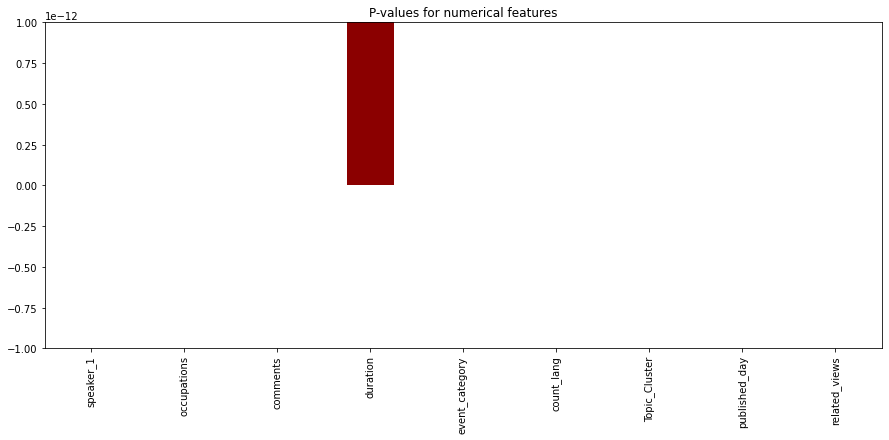

In [313]:
p_series.plot(kind='bar',color='darkred')

plt.title('P-values for numerical features')

We can drop duration column

In [314]:
X.drop(columns=['duration'],inplace= True)


#**Model Selection:**

## Decision Tree: Non-paramteric model with good interpretibility.

Directly moving to Tree based non-parametric algorithm as:

1. Linear relationship not required

2. Faster and easily interpretable.

In [315]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [316]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [319]:
from sklearn.tree import DecisionTreeRegressor

In [321]:
regressor = DecisionTreeRegressor(max_leaf_nodes=10, random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [322]:
y_predicted =regressor.predict(X_test)

In [323]:
def smape(actual, pred):
    return 1/len(actual) * np.sum(2 * np.abs(pred-actual) / (np.abs(actual) + np.abs(pred))*100)

In [325]:
#Train SMAPE

smape(y_train,regressor.predict(X_train))


20.562830209906593

In [326]:
#Test Smape

smape(y_predicted,y_test)

21.59885919747428

Test SMAPE is greater than Train. The model is underfitting. Applying Bagging to solve this.

# RandomForest Regressor:

In [334]:
from sklearn.ensemble import RandomForestRegressor

In [335]:
from sklearn.model_selection import RandomizedSearchCV

In [336]:
#Random Forest Regressor param_dict
n_estimators = [30,50,80,100,120,150]
max_depth = [4,6,8,10,12]
min_samples_split = [50,80,100,150,200]
min_samples_leaf = [10,30,40,50,60,80]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor(criterion='mae')

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [337]:
#Building optimal model on the best estimators
rf_optimal_model = rf_random.best_estimator_

In [338]:
# make predictions for test data
y_hat = rf_optimal_model.predict(X_test)

In [339]:
print(f'r_sqr value for train: {rf_optimal_model.score(X_train, y_train)}')

r_sqr value for train: 0.860430047913237


In [340]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [341]:
r_squared= r2_score(y_test,y_hat)

In [342]:
#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print(f'The R_Squared for XGBoost is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')


The R_Squared for XGBoost is 0.8310488919645169 for train and adjusted R_Squared is 0.8307106515079894


In [343]:
import math

In [346]:
print(f'The Root Mean Squared Error for Random Forest is: {math.sqrt(mean_squared_error(y_test,y_hat))}')

The Root Mean Squared Error for Random Forest is: 456891.2559844491


In [347]:
print(f'The mean absolute error for Random Forest is: {mean_absolute_error(y_test,y_hat)}')

The mean absolute error for Random Forest is: 195820.5784397871


In [348]:
print(f'The error percentage for Random Forest is : {round((mean_absolute_error(y_test,y_hat)/Y.mean()*100),2)}% of views')

The error percentage for Random Forest is : 11.79% of views


In [349]:
topic=[]

smape_train=[]


smape_test=[]

In [350]:
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [351]:
smape_train.append(smape(y_train,xgb_optimal_model.predict(X_train)))

smape_test.append(smape(y_test,y_hat))

In [352]:
topic.append('All')

In [353]:
mape(y_test,y_hat)

23.54667471862107

In [354]:
smape(y_test,y_hat)

13.49140853073512

Smape is better than Mape because MAPE is asymmetric in that ‘equal errors above the actual value result in a greater APE than those below the actual value’. Similarly, Armstrong and Collopy argued that ‘the MAPE ... puts a heavier penalty on forecasts that exceed the actual than those that are less than the actual. For example, the MAPE is bounded on the low side by an error of 100%, but there is no bound on the high side’.

# **Checking Views for each of the topic clusters:**

In [357]:
data_t.head(1)

,speaker_1,occupations,views,comments,duration,event_category,count_lang,Topic_Cluster,published_day,related_views
0,Al Gore,climate advocate,3523392.0,272.0,977.0,TED2000s,43.0,International Affairs,Tuesday,1659584.0


### **1. Technology:**

In [358]:
technology= data_t[data_t['Topic_Cluster']=='Technology']

**Feature Engineering:**

In [359]:
technology.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426 entries, 2 to 4000
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       1426 non-null   object 
 1   occupations     1426 non-null   object 
 2   views           1426 non-null   float64
 3   comments        1426 non-null   float64
 4   duration        1426 non-null   float64
 5   event_category  1426 non-null   object 
 6   count_lang      1426 non-null   float64
 7   Topic_Cluster   1426 non-null   object 
 8   published_day   1426 non-null   object 
 9   related_views   1426 non-null   float64
dtypes: float64(5), object(5)
memory usage: 122.5+ KB


In [360]:
technology.drop(columns= 'Topic_Cluster',inplace= True)

Target Encoding:

In [361]:
categorical_features= ['speaker_1','occupations','event_category','published_day']

In [362]:
for column in categorical_features:
  technology[column] = technology[column].map(technology.groupby(column)['views'].mean())

In [363]:
technology.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426 entries, 2 to 4000
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       1426 non-null   float64
 1   occupations     1426 non-null   float64
 2   views           1426 non-null   float64
 3   comments        1426 non-null   float64
 4   duration        1426 non-null   float64
 5   event_category  1426 non-null   float64
 6   count_lang      1426 non-null   float64
 7   published_day   1426 non-null   float64
 8   related_views   1426 non-null   float64
dtypes: float64(9)
memory usage: 111.4 KB


Feature selection:

In [364]:
X= technology.drop(columns='views')

Y= technology['views']

In [365]:
f_scores = f_regression(X,Y)
f_scores

(array([11529.86382181,  1274.79777352,   512.29992614,    18.88169391,
           48.55923282,   448.25897986,    22.56128461,   295.92594331]),
 array([0.00000000e+000, 6.21529626e-200, 3.86893233e-097, 1.48942911e-005,
        4.88420606e-012, 1.02127065e-086, 2.24090477e-006, 2.09889644e-060]))

In [366]:
#The second array consists of p-values that we need

p_series= pd.Series(f_scores[1],index= X.columns)

Text(0.5, 1.0, 'P-values for numerical features')

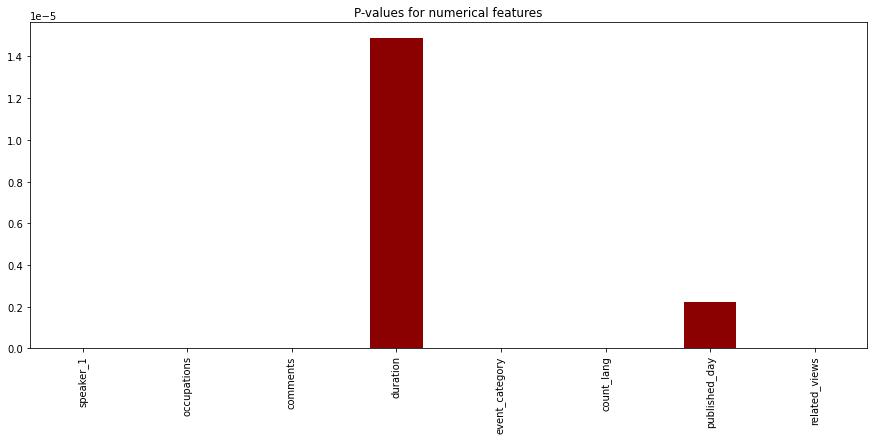

In [367]:
p_series.plot(kind='bar',color='darkred')

plt.title('P-values for numerical features')

We can keep all the features.

XGBoost:

In [368]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [369]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [370]:
#Random Forest Regressor param_dict
n_estimators = [50,80,100]
max_depth = [4,6,8]
min_samples_split = [50,80,100]
min_samples_leaf = [30,40,50]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor(criterion='mae')

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [371]:
#Building optimal model on the best estimators
rf_model = rf_random.best_estimator_

In [372]:
# make predictions for test data
y_hat = rf_model.predict(X_test)

In [373]:
smape(y_test,y_hat)

13.524895433228782

In [374]:
smape_train.append(smape(y_train,rf_model.predict(X_train)))

smape_test.append(smape(y_test,y_hat))

topic.append('Technology')

## **2.International Affairs:**

In [375]:
international= data_t[data_t['Topic_Cluster']=='International Affairs']

**Feature Enigneering:**

In [376]:
international.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 4002
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       818 non-null    object 
 1   occupations     818 non-null    object 
 2   views           818 non-null    float64
 3   comments        818 non-null    float64
 4   duration        818 non-null    float64
 5   event_category  818 non-null    object 
 6   count_lang      818 non-null    float64
 7   Topic_Cluster   818 non-null    object 
 8   published_day   818 non-null    object 
 9   related_views   818 non-null    float64
dtypes: float64(5), object(5)
memory usage: 70.3+ KB


In [377]:
international.drop(columns= 'Topic_Cluster',inplace= True)

Target Encoding:

In [378]:
categorical_features= ['speaker_1','occupations','event_category','published_day']

In [379]:
for column in categorical_features:
  international[column] = international[column].map(international.groupby(column)['views'].mean())

In [380]:
international.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 4002
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       818 non-null    float64
 1   occupations     818 non-null    float64
 2   views           818 non-null    float64
 3   comments        818 non-null    float64
 4   duration        818 non-null    float64
 5   event_category  818 non-null    float64
 6   count_lang      818 non-null    float64
 7   published_day   818 non-null    float64
 8   related_views   818 non-null    float64
dtypes: float64(9)
memory usage: 63.9 KB


Feature Selection:

In [381]:
X= international.drop(columns='views')

Y= international['views']

In [382]:
f_scores = f_regression(X,Y)
f_scores

(array([5533.48761212,  866.69766269,   80.47051107,    8.16102352,
          43.80966824,   70.78120314,   30.36534421,   77.65567318]),
 array([0.00000000e+000, 2.23168125e-130, 1.99103208e-018, 4.38880459e-003,
        6.55288599e-011, 1.77604234e-016, 4.80033440e-008, 7.29770313e-018]))

In [383]:
#The second array consists of p-values that we need

p_series= pd.Series(f_scores[1],index= X.columns)

Text(0.5, 1.0, 'P-values for numerical features')

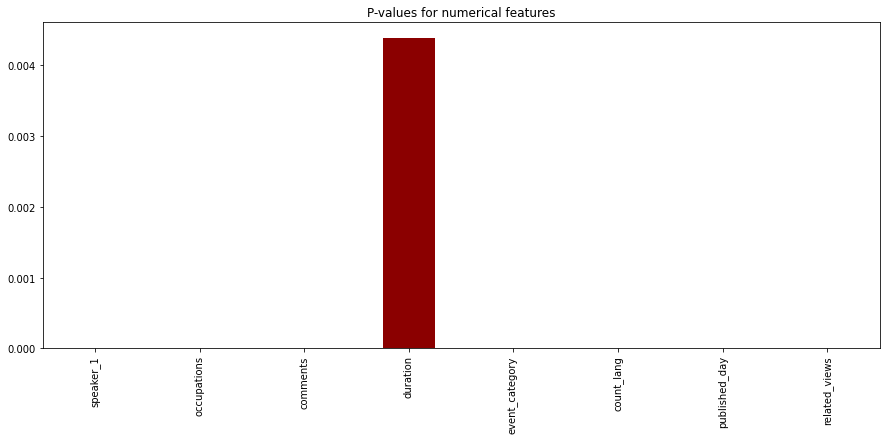

In [384]:
p_series.plot(kind='bar',color='darkred')

plt.title('P-values for numerical features')

Cannot drop any column.

XGBoost:

In [385]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [386]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [387]:
#Random Forest Regressor param_dict
n_estimators = [50,80,100]
max_depth = [4,6,8]
min_samples_split = [50,80,100]
min_samples_leaf = [30,40,50]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor(criterion='mae')

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [388]:
#Building optimal model on the best estimators
rf_model = rf_random.best_estimator_

In [389]:
# make predictions for test data
y_hat = rf_model.predict(X_test)

In [390]:
smape_train.append(smape(y_train,rf_model.predict(X_train)))

smape_test.append(smape(y_test,y_hat))

topic.append('International Affairs')

## **3. Science:**

In [391]:
science= data_t[data_t['Topic_Cluster']=='Science']

### **Feature Engineering**

In [392]:
science.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 24 to 4004
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       630 non-null    object 
 1   occupations     630 non-null    object 
 2   views           630 non-null    float64
 3   comments        630 non-null    float64
 4   duration        630 non-null    float64
 5   event_category  630 non-null    object 
 6   count_lang      630 non-null    float64
 7   Topic_Cluster   630 non-null    object 
 8   published_day   630 non-null    object 
 9   related_views   630 non-null    float64
dtypes: float64(5), object(5)
memory usage: 54.1+ KB


In [393]:
science.drop(columns= 'Topic_Cluster',inplace= True)

Target Encoding:

In [394]:
for column in categorical_features:
  science[column] = science[column].map(science.groupby(column)['views'].mean())

In [395]:
science.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 24 to 4004
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       630 non-null    float64
 1   occupations     630 non-null    float64
 2   views           630 non-null    float64
 3   comments        630 non-null    float64
 4   duration        630 non-null    float64
 5   event_category  630 non-null    float64
 6   count_lang      630 non-null    float64
 7   published_day   630 non-null    float64
 8   related_views   630 non-null    float64
dtypes: float64(9)
memory usage: 49.2 KB


Feature Selection:

In [396]:
X= science.drop(columns='views')

Y= science['views']

In [397]:
f_scores = f_regression(X,Y)
f_scores

(array([4.41447779e+03, 4.03226532e+02, 9.74559398e+01, 9.33981863e-01,
        4.67005866e+01, 1.16739706e+02, 1.39741859e+01, 1.95593618e+01]),
 array([2.88858825e-286, 1.17969667e-069, 1.82732457e-021, 3.34202389e-001,
        1.96022580e-011, 4.48187724e-025, 2.02256950e-004, 1.14931387e-005]))

In [398]:
#The second array consists of p-values that we need

p_series= pd.Series(f_scores[1],index= X.columns)

Text(0.5, 1.0, 'P-values for numerical features')

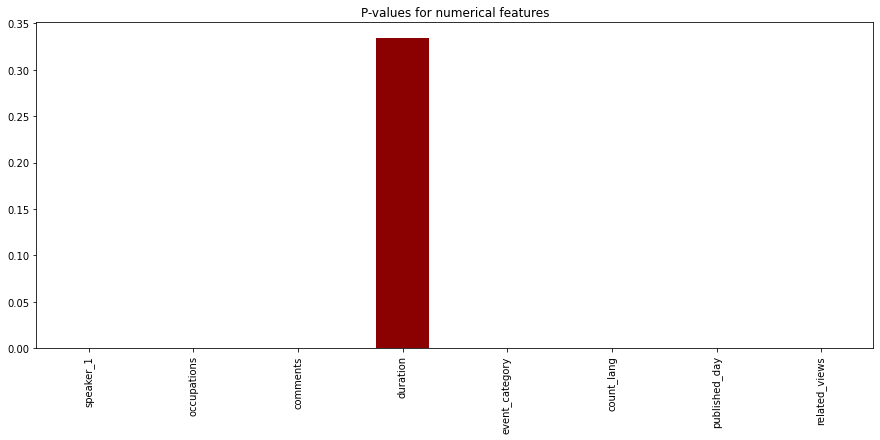

In [399]:
p_series.plot(kind='bar',color='darkred')

plt.title('P-values for numerical features')

We can keep all columns

In [400]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [401]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [402]:
#Random Forest Regressor param_dict
n_estimators = [50,80,100]
max_depth = [4,6,8]
min_samples_split = [50,80,100]
min_samples_leaf = [30,40,50]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor(criterion='mae')

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [403]:
#Building optimal model on the best estimators
rf_model = rf_random.best_estimator_

In [404]:
# make predictions for test data
y_hat = rf_model.predict(X_test)

In [405]:
smape_train.append(smape(y_train,rf_model.predict(X_train)))

smape_test.append(smape(y_test,y_hat))

topic.append('Science')

In [406]:
topic

['All', 'Technology', 'International Affairs', 'Science']

# **Comparing scores of the most popular spoken topics:**

In [407]:
scores= pd.DataFrame({'SMAPE_TRAIN':smape_train, 'SMAPE_TEST':smape_test, 'TOPIC':topic})

<Figure size 1440x720 with 0 Axes>

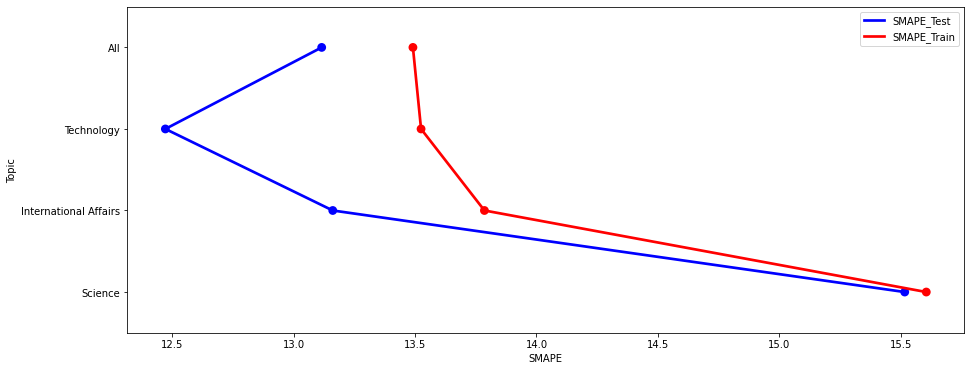

In [408]:
ax=plt.figure(figsize=(20,10))
# creating subplots
ax = plt.subplots()
# plotting columns
ax = sns.pointplot(x=scores["SMAPE_TRAIN"], y=scores["TOPIC"], color='b',alpha=0.2,labels=('SMAPE SCORE TRAIN'))
ax = sns.pointplot(x=scores["SMAPE_TEST"], y=scores["TOPIC"], color='r',alpha=0.7,labels=('SMAPE SCORE TEST'))
# renaming the axes
ax.set(xlabel="SMAPE", ylabel="Topic")
ax.legend(handles=ax.lines[::len(scores)+1], labels=["SMAPE_Test","SMAPE_Train"])


# visulaizing illustration
plt.show()

International Affairs has the lowest SMAPE train and test. Our model has made the best predictions in this category.